In [ ]:
# Variational AutoEncoder (VAE)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

In [ ]:
# load dataset
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


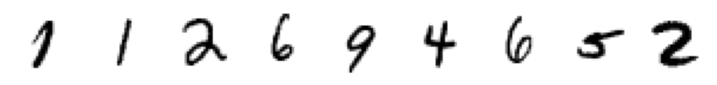

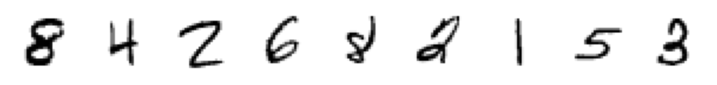

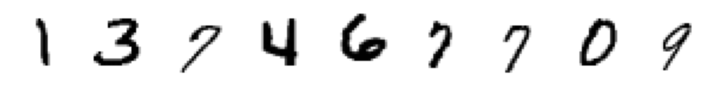

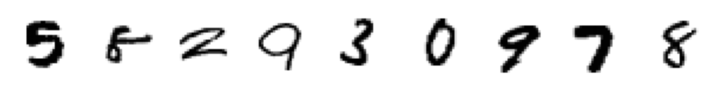

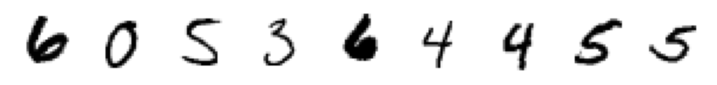

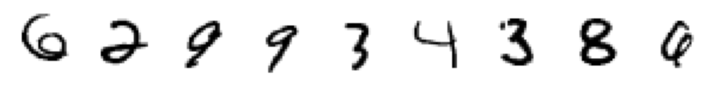

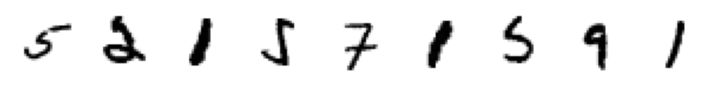

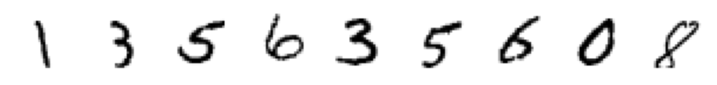

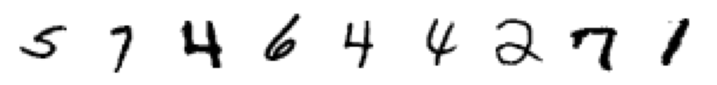

In [ ]:
# show dataset
for k in range(9):
    plt.figure(figsize=(9,9))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        plt.axis('off')
        #plt.title(trainy[i])
    plt.show()

In [ ]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# encoder: image to latent space

input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))

encoder = tensorflow.keras.layers.Conv2D(64, (5,5), activation='relu')(input_data)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(64, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Conv2D(32, (3,3), activation='relu')(encoder)
encoder = tensorflow.keras.layers.MaxPooling2D((2,2))(encoder)

encoder = tensorflow.keras.layers.Flatten()(encoder)
encoder = tensorflow.keras.layers.Dense(16)(encoder)

In [ ]:
# sampling
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
# mean, variance, sampling layers
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
sampled_latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
# image and sample noise passed to encoder
encoder_model = tensorflow.keras.Model(input_data, sampled_latent_encoding)
encoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 24, 24, 64)           1664      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 64)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 10, 10, 64)           36928     ['max_pooling2d_3[0][0]'

In [ ]:
# decoder : latent space to image
decoder_input = tensorflow.keras.layers.Input(shape=(2))
decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)
decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder)
decoder = tensorflow.keras.layers.UpSampling2D((2,2))(decoder)

decoder_output = tensorflow.keras.layers.Conv2DTranspose(1, (5,5), activation='relu')(decoder)

In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                192       
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 64)          0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 3, 3, 64)          36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 5, 5, 64)          36928     
 Transpose)                                                      
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 10, 10, 64)        0   

In [ ]:
# trained using backpropagation
sampled_latent_encoding = encoder_model(input_data)
decoded = decoder_model(sampled_latent_encoding)
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [ ]:
# Loss Function (Reconstruction Loss + KL-divergence-loss)
def get_loss(distribution_mean, distribution_variance):

    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28

    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [ ]:
# vae model
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_3 (Functional)        (None, 2)                 57652     
                                                                 
 model_4 (Functional)        (None, 28, 28, 1)         112577    
                                                                 
Total params: 170229 (664.96 KB)
Trainable params: 170229 (664.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
autoencoder.fit(train_data, train_data, epochs=3, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 199s 3ms/sample - loss: 36.5859 - val_loss: 36.0225
Epoch 2/3
60000/60000 [==============================] - 198s 3ms/sample - loss: 35.9594 - val_loss: 35.5026
Epoch 3/3
60000/60000 [==============================] - 201s 3ms/sample - loss: 35.5417 - val_loss: 35.3108


Real Test Images


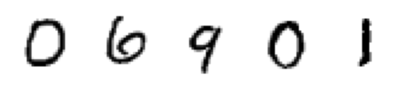

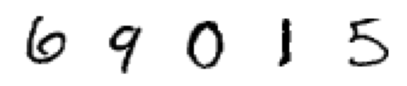

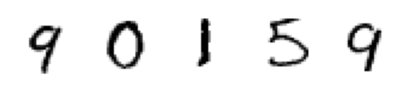

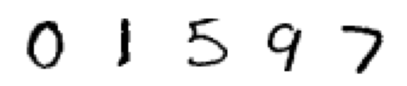

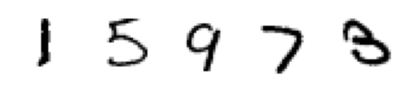

In [ ]:
i = 10
print ("Real Test Images")
# Real Images
for k in range(5):
    plt.figure(figsize=(5,5))
    for j in range(5):
        plt.subplot(550 + 1 + j)
        plt.imshow(test_data[k+j+i,:,:, -1], cmap='gray_r')
        plt.axis('off')
    plt.show()

Reconstructed Images with Variational Autoencoder


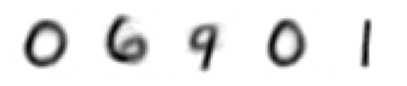

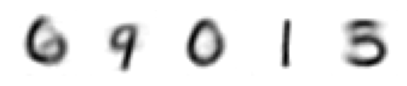

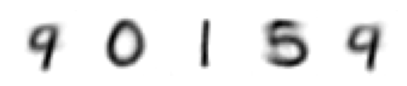

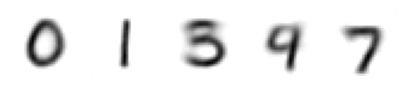

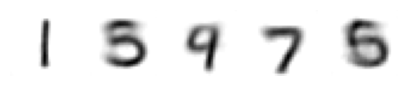

In [ ]:
# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for k in range(5):
    plt.figure(figsize=(5,5))
    for j in range(5):
        plt.subplot(550 + 1 + j)
        output = autoencoder.predict(np.array([test_data[k+j+i]]))
        op_image = np.reshape(output[0]*255, (28, 28))
        plt.imshow(op_image, cmap='gray_r')
        plt.axis('off')
    plt.show()

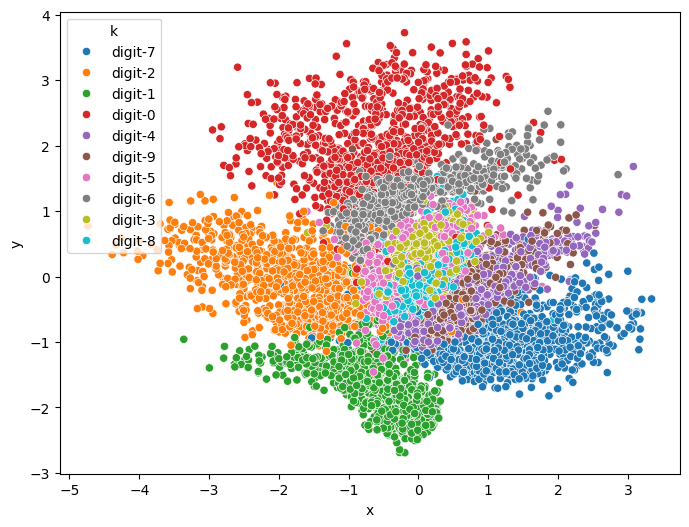

In [ ]:
# plot latent distribustion : classes
x = []
y = []
k = []
for i in range(10000):
    k.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['k'] = ["digit-"+str(i) for i in k]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='k', data=df)
plt.show()